# NASA Turbofan Engine Simulated Failures


**Download Dataset** 

https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

**Background**

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 

The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

In [54]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from btb.tuning import GP, Uniform
from btb import HyperParameter, ParamTypes

# Read Data

In [60]:
folder = r'C:\Users\Siyang\Downloads\CMAPSSData'
df_rul = pd.read_table(os.path.join(folder,'RUL_FD001.txt'), header=None)
df_train = pd.read_table(os.path.join(folder, 'train_FD001.txt'), sep=' ', header=None)
df_test = pd.read_table(os.path.join(folder, 'test_FD001.txt'), sep=' ', header=None)

In [61]:
# remove redundant columns due to extra spacing
df_train = df_train[df_train.columns[:26]]
df_test = df_test[df_test.columns[:26]]

In [62]:
# see data structure
print('RUL: ', df_rul.shape)
print('Train: ', df_train.shape)
print('Test: ', df_test.shape)

RUL:  (100, 1)
Train:  (20631, 26)
Test:  (13096, 26)


# Feature List

 * 1)	unit number
 * 2)	time, in cycles
 * 3)	operational setting 1
 * 4)	operational setting 2
 * 5)	operational setting 3
 * 6)	sensor measurement  1
 * 7)	sensor measurement  2
 * ...
 * 26)	sensor measurement  26

# Preprocess Train

In [63]:
df_train.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)

total_cycles = df_train.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)

df_train = df_train.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
df_train['RUL'] = df_train.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)


df_train2 = df_train.copy()
del df_train2['cycle']

X_train = df_train2[df_train2.columns[:25]]
y_train = df_train['RUL']

# Preprocess Test

In [64]:
# number of engines
engines = df_test[0].unique()

df_list = []
# get last cycle for each engine
for i in engines:
    df = df_test[df_test[0]==i]
    last = (df[-1:])
    df_list.append(last)

# union all rows in a dataframe
X_test = pd.concat(df_list)
del X_test[1]

In [65]:
y_test = df_rul.values.flatten()

# Bayesian Optimization

In [85]:
def auto_tuning(tunables, epoch, X_train, X_test, y_train, y_test, verbose=0):
    """Auto-tuner using BTB library"""
    tuner = GP(tunables)
    parameters = tuner.propose()

    score_list = []
    param_list = []

    for i in range(epoch):
        # ** unpacks dict in a argument
        model = RandomForestRegressor(**parameters, n_jobs=-1)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        score = mean_absolute_error(y_test, y_predict)

        if verbose==0:
            pass
        elif verbose==1:
            print('epoch: {}, MAE: {}'.format(i+1,score))
        elif verbose==2:
            print('epoch: {}, MAE: {}, param: {}'.format(i+1,score,parameters))
            
        score = 100 - score
        # store scores & parameters
        score_list.append(score)
        param_list.append(parameters)

        # get new parameters
        tuner.add(parameters, score)
        parameters = tuner.propose()

    best_s = tuner._best_score
    best_score_index = score_list.index(best_s)
    best_param = param_list[best_score_index]
    print('\nbest accuracy: {}'.format(100-best_s))
    print('best parameters: {}'.format(best_param))
    return best_param


tunables = [('n_estimators', HyperParameter(ParamTypes.INT, [500, 2000])),
            ('max_depth', HyperParameter(ParamTypes.INT, [3, 20]))]

best_param = auto_tuning(tunables, 25, X_train, X_test, y_train, y_test, 2)

epoch: 1, MAE: 23.26377013854677, param: {'n_estimators': 1765, 'max_depth': 12}
epoch: 2, MAE: 22.679192199996134, param: {'n_estimators': 1058, 'max_depth': 9}
epoch: 3, MAE: 22.937948992239168, param: {'n_estimators': 1058, 'max_depth': 11}
epoch: 4, MAE: 22.69573420653577, param: {'n_estimators': 1057, 'max_depth': 9}
epoch: 5, MAE: 23.89836738533487, param: {'n_estimators': 1060, 'max_depth': 7}
epoch: 6, MAE: 22.88736074445585, param: {'n_estimators': 1058, 'max_depth': 10}
epoch: 7, MAE: 25.107970547059235, param: {'n_estimators': 1056, 'max_depth': 6}
epoch: 8, MAE: 23.0546772327079, param: {'n_estimators': 1058, 'max_depth': 12}
epoch: 9, MAE: 23.338227594744126, param: {'n_estimators': 1056, 'max_depth': 13}
epoch: 10, MAE: 22.826640321408668, param: {'n_estimators': 1058, 'max_depth': 11}


C:\Users\Siyang\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


epoch: 11, MAE: 22.82529895531612, param: {'n_estimators': 1058, 'max_depth': 10}
epoch: 12, MAE: 22.94824059884512, param: {'n_estimators': 1058, 'max_depth': 8}
epoch: 13, MAE: 22.75586220681919, param: {'n_estimators': 1062, 'max_depth': 11}
epoch: 14, MAE: 22.769839240882575, param: {'n_estimators': 1057, 'max_depth': 10}
epoch: 15, MAE: 22.83369704490951, param: {'n_estimators': 1061, 'max_depth': 11}
epoch: 16, MAE: 22.73486543653694, param: {'n_estimators': 1069, 'max_depth': 10}
epoch: 17, MAE: 22.81989883544827, param: {'n_estimators': 1057, 'max_depth': 10}
epoch: 18, MAE: 22.602972400473718, param: {'n_estimators': 1056, 'max_depth': 9}
epoch: 19, MAE: 22.810906754832434, param: {'n_estimators': 1069, 'max_depth': 11}
epoch: 20, MAE: 22.707479271328467, param: {'n_estimators': 1055, 'max_depth': 9}
epoch: 21, MAE: 22.757479005669254, param: {'n_estimators': 1056, 'max_depth': 10}
epoch: 22, MAE: 23.014246625720673, param: {'n_estimators': 1061, 'max_depth': 11}
epoch: 23, MA

# Fit Model

In [86]:
model = RandomForestRegressor(**best_param, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1056, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Feature Importance

In [87]:
f_impt= pd.DataFrame(model.feature_importances_, index=X_train.columns)
f_impt = f_impt.sort_values(by=0,ascending=False)
f_impt.columns = ['feature importance']
f_impt

,feature importance
15,0.553843
13,0.133312
unit,0.114426
8,0.083669
16,0.033472
11,0.017704
18,0.016382
19,0.008358
17,0.008301
25,0.006792


# Plot Degradation

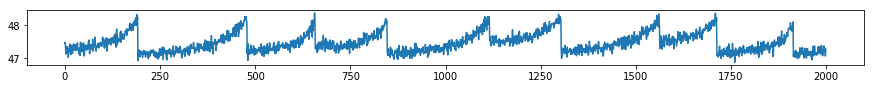

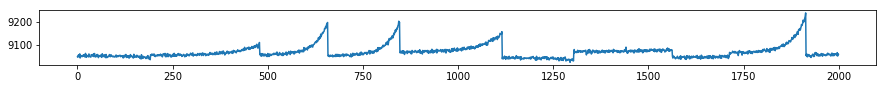

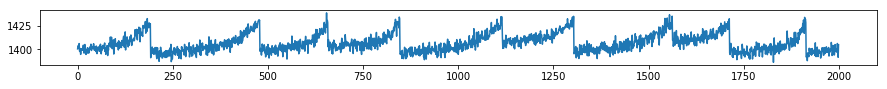

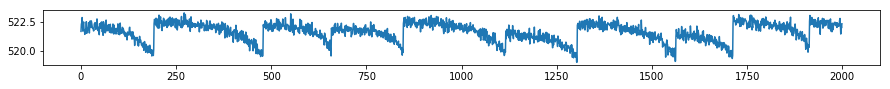

In [88]:
sensors = [15,13,8,16]

for i in sensors:
    plt.figure(figsize=(15,1))
    plt.plot(X_train[i][:2000]);

# Get Model R-Squared

In [89]:
r2_train = model.score(X_train, y_train)
print('model fit:', r2_train)

model fit: 0.7926583291493039


# Get RMSE & MAE

In [90]:
y_predicted_train = model.predict(X_train)
y_predicted_test = model.predict(X_test)

In [91]:
MSE_train = mean_squared_error(y_train, y_predicted_train)
MSE_test = mean_squared_error(y_test, y_predicted_test)

print('Train RMSE:', np.sqrt(MSE_train))
print('Test RMSE:', np.sqrt(MSE_test))

Train RMSE: 31.36405111629327
Test RMSE: 32.35509563551364


In [92]:
MAE_train = mean_absolute_error(y_train, y_predicted_train)
MAE_test = mean_absolute_error(y_test, y_predicted_test)

print('Train MAE', MAE_train)
print('Train MAE', MAE_test)

Train MAE 22.824544910375984
Train MAE 22.615222061546355
